In [19]:
from gensim.corpora import Dictionary 

In [20]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import requests
from collections import defaultdict 
from gensim.models import HdpModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD, NMF

from sklearn.feature_extraction.text import TfidfVectorizer


In [21]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [token.translate(table) for token in tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove empty tokens
    tokens = [token for token in tokens if token.strip()]
    
    return tokens


def create_dtm(text):
    dtm = defaultdict(dict)
    lines = text.strip().split('\n')
    document_frequency = defaultdict(int)  # stores document frequency for each word
    
    # Processing each line
    for line in lines:
        parts = line.split('\t')
        if len(parts) == 2:
            verse = parts[0]
            verse_text = parts[1]
            verse_text = preprocess_text(verse_text)
            
            # Unique word set for each document
            unique_words = set(verse_text)
            
            # Updating document frequency
            for word in unique_words:
                document_frequency[word] += 1
            
            # Updating Document-Term Matrix (DTM)
            for word in verse_text:
                if word in dtm[verse]:
                    dtm[verse][word] += 1
                else:
                    dtm[verse][word] = 1
    
    # Filter tokens based on document frequency
    total_documents = len(lines)
    min_doc_freq = 5
    max_doc_freq_ratio = 0.5
    
    words_to_remove = []
    for verse, word_counts in dtm.items():
        for word, count in word_counts.items():
            if document_frequency[word] < min_doc_freq or document_frequency[word] / total_documents > max_doc_freq_ratio:
                words_to_remove.append((verse, word))
    
    # Remove filtered words
    for verse, word in words_to_remove:
        del dtm[verse][word]
    
    return dtm


In [22]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [token.translate(table) for token in tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove empty tokens and tokens with length less than 2
    tokens = [token for token in tokens if token.strip() and len(token) > 1]
    
    return tokens

def create_dtm(text):
    dtm = defaultdict(dict)
    lines = text.strip().split('\n')        
    for idx, line in enumerate(lines):
        # Treat each line as a separate document
        verse = f"Line {idx + 1}"
        verse_text = preprocess_text(line)
        for word in verse_text:
            if word in dtm[verse]:
                dtm[verse][word] += 1
            else:
                dtm[verse][word] = 1
                        
    return dtm

# Path to the English Genesis file
eng_genesis_path = 'data/genesis_english.txt'
with open(eng_genesis_path, 'r') as file:
    eng_genesis_text = file.read()

# Preprocess the text
preprocessed_text = ' '.join(preprocess_text(eng_genesis_text))

# Print preprocessed text
print("Preprocessed text:", preprocessed_text[:100])  # printing only the first 100 characters for brevity

# Create the Document-Term Matrix (DTM)
dtm = create_dtm(eng_genesis_text)

# Print the DTM
print("\nDocument-Term Matrix (DTM):")
for verse, word_counts in dtm.items():
    print(verse)
    for word, count in word_counts.items():
        print(f"{word}: {count}", end=", ")
    print("\n")


Preprocessed text: begin god creat heaven earth earth without form void dark face deep spirit god move face water god s

Document-Term Matrix (DTM):
Line 1
begin: 1, god: 1, creat: 1, heaven: 1, earth: 1, 

Line 2
earth: 1, without: 1, form: 1, void: 1, dark: 1, face: 2, deep: 1, spirit: 1, god: 1, move: 1, water: 1, 

Line 3
god: 1, said: 1, let: 1, light: 2, 

Line 4
god: 2, saw: 1, light: 2, good: 1, divid: 1, dark: 1, 

Line 5
god: 1, call: 2, light: 1, day: 2, dark: 1, night: 1, even: 1, morn: 1, first: 1, 

Line 6
god: 1, said: 1, let: 2, firmament: 1, middl: 1, water: 3, divid: 1, 

Line 7
god: 1, made: 1, firmament: 3, divid: 1, water: 2, 

Line 8
god: 1, call: 1, firmament: 1, heaven: 1, even: 1, morn: 1, second: 1, day: 1, 

Line 9
god: 1, said: 1, let: 2, water: 1, heaven: 1, gather: 1, togeth: 1, one: 1, place: 1, dri: 1, land: 1, appear: 1, 

Line 10
god: 2, call: 2, dri: 1, land: 1, earth: 1, gather: 1, togeth: 1, water: 1, sea: 1, saw: 1, good: 1, 

Line 11
god: 1, said:

In [23]:
from gensim import corpora, models
# Create a list of tokenized documents
documents = [[word for word in word_counts.keys()] for word_counts in dtm.values()]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(documents)

# Create a bag-of-words representation of the corpus
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Apply LDA
num_topics = 5
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

# Print the topics
print("Top words for each topic:")
for topic_idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {topic_idx}: {topic}")

Top words for each topic:
Topic 0: 0.037*"said" + 0.021*"god" + 0.019*"father" + 0.019*"lord" + 0.014*"land" + 0.011*"joseph" + 0.011*"bless" + 0.010*"came" + 0.009*"shall" + 0.009*"jacob"
Topic 1: 0.026*"son" + 0.022*"shall" + 0.014*"said" + 0.014*"abraham" + 0.010*"earth" + 0.009*"god" + 0.009*"lord" + 0.009*"land" + 0.009*"went" + 0.009*"water"
Topic 2: 0.019*"son" + 0.018*"jacob" + 0.013*"said" + 0.012*"brother" + 0.012*"land" + 0.011*"joseph" + 0.011*"father" + 0.010*"went" + 0.010*"daughter" + 0.008*"hundr"
Topic 3: 0.034*"said" + 0.018*"shall" + 0.016*"god" + 0.014*"came" + 0.014*"son" + 0.013*"brother" + 0.012*"behold" + 0.011*"lord" + 0.009*"come" + 0.009*"father"
Topic 4: 0.021*"said" + 0.017*"son" + 0.016*"day" + 0.010*"wife" + 0.010*"shall" + 0.009*"lord" + 0.009*"jacob" + 0.008*"came" + 0.008*"abraham" + 0.008*"year"


In [24]:
# Step 1: Preprocess text
preprocessed_text = [preprocess_text(verse_text) for verse_text in eng_genesis_text.split('\n')]

# Step 2: Create a dictionary and document-term matrix
dictionary = Dictionary(preprocessed_text)
corpus = [dictionary.doc2bow(text) for text in preprocessed_text]

# Step 3: Apply HDP model
hdp_model = HdpModel(corpus, dictionary)

# Get topics
topics = hdp_model.show_topics()
for topic in topics:
    print(topic)

(0, '0.005*number + 0.005*vale + 0.004*uz + 0.004*pluck + 0.004*grass + 0.003*admah + 0.003*hanoch + 0.003*man + 0.003*beheld + 0.003*substanc + 0.003*brother + 0.003*ask + 0.003*piec + 0.003*seed + 0.003*shut + 0.003*pharaoh + 0.003*shall + 0.003*best + 0.002*vengeanc + 0.002*wrong')
(1, '0.004*arvadit + 0.004*sheba + 0.004*men + 0.004*reprov + 0.003*bring + 0.003*onam + 0.003*height + 0.003*twentieth + 0.003*abid + 0.003*split + 0.003*blame + 0.003*form + 0.003*inhabit + 0.003*clear + 0.003*wick + 0.003*spice + 0.003*cattl + 0.003*hagar + 0.003*like + 0.003*colt')
(2, '0.004*handl + 0.004*blind + 0.004*flee + 0.004*bilhan + 0.004*run + 0.003*tempt + 0.003*stuff + 0.003*though + 0.003*serpent + 0.003*drink + 0.003*damsel + 0.003*maiden + 0.003*beerlahairoi + 0.003*gerar + 0.003*rosh + 0.003*tell + 0.003*jahzeel + 0.003*esek + 0.003*strake + 0.003*concept')
(3, '0.004*much + 0.004*driven + 0.004*conceiv + 0.004*prosper + 0.004*blossom + 0.003*lasha + 0.003*lightli + 0.003*pigeon + 0.00

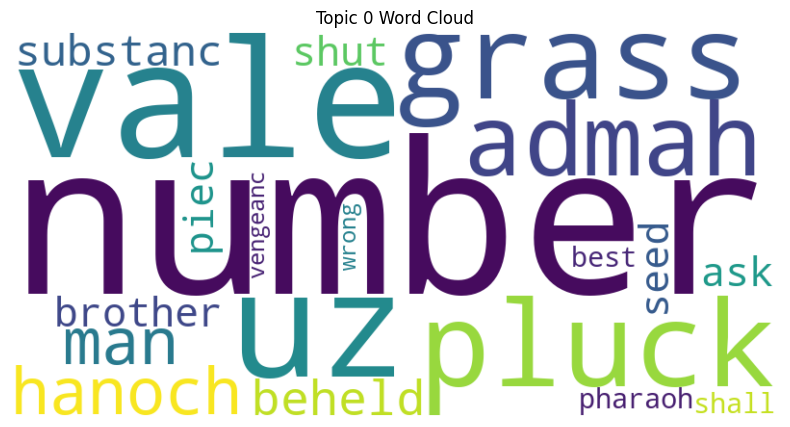

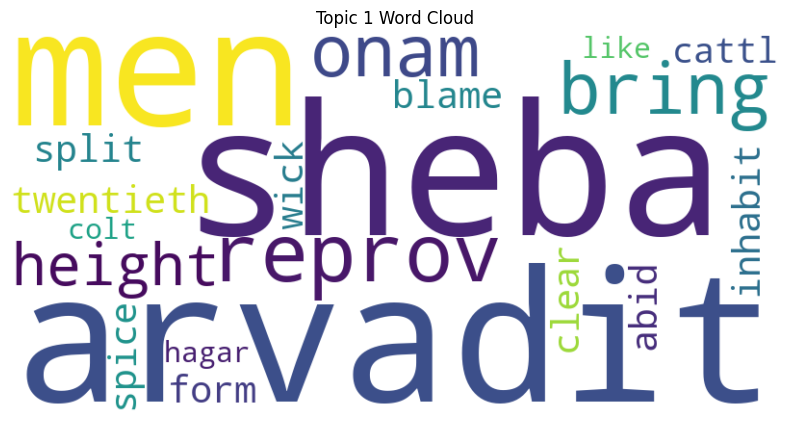

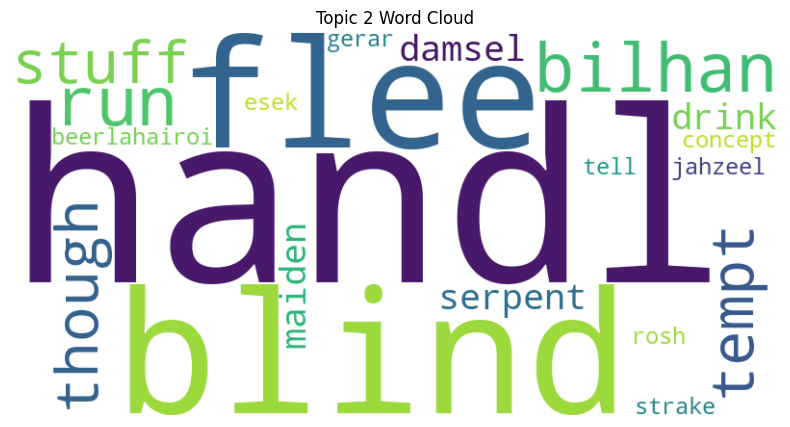

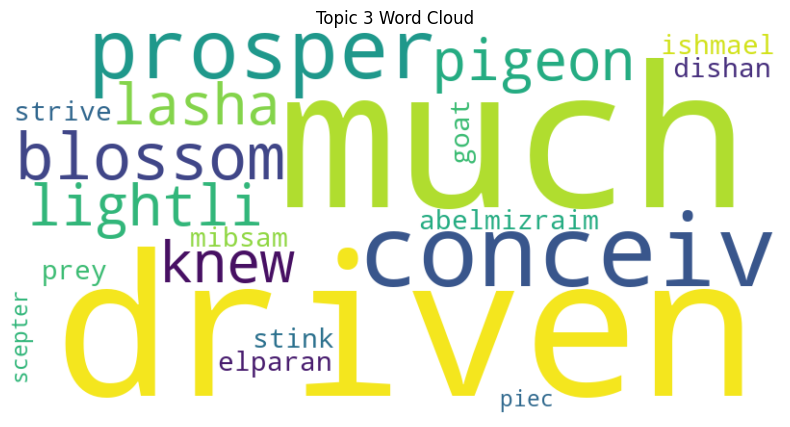

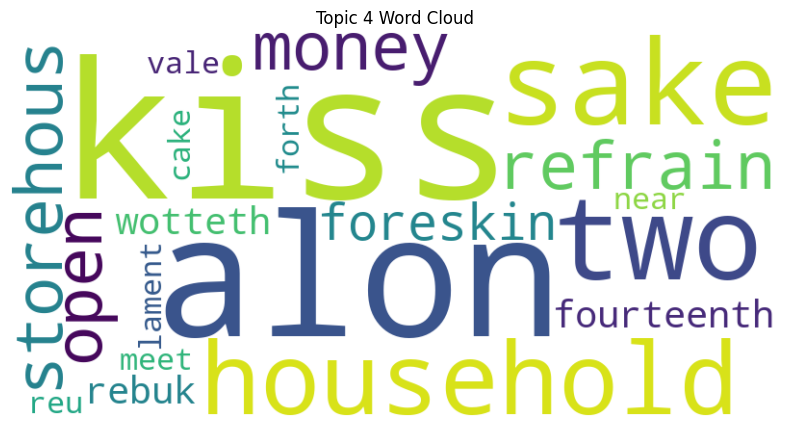

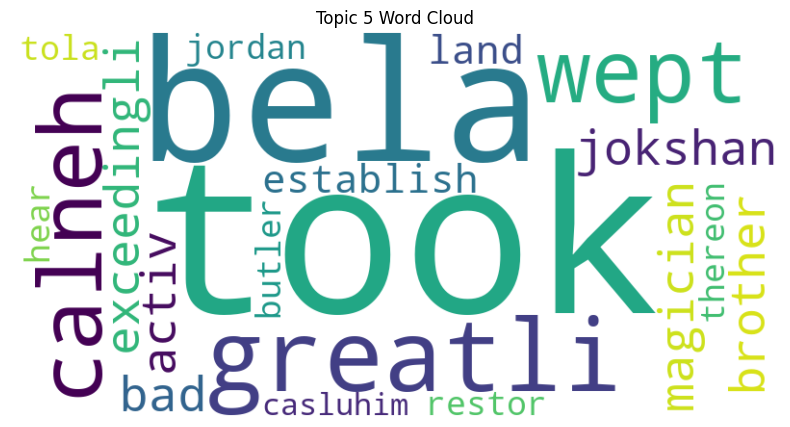

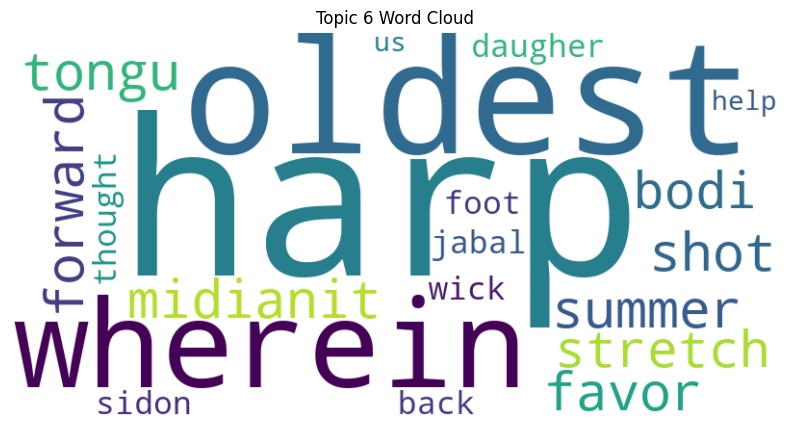

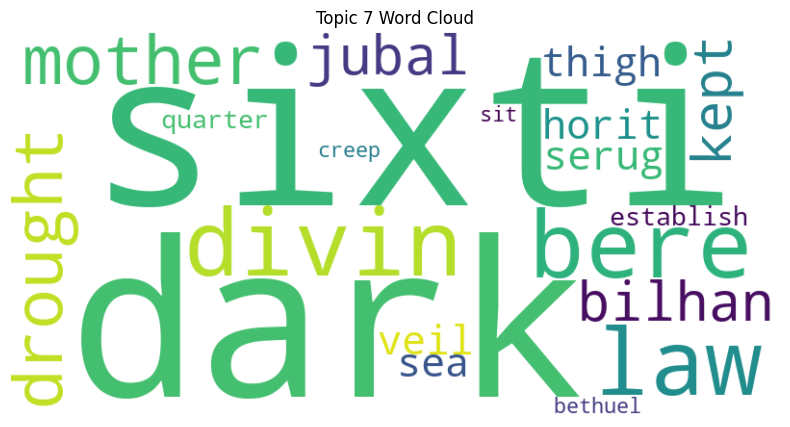

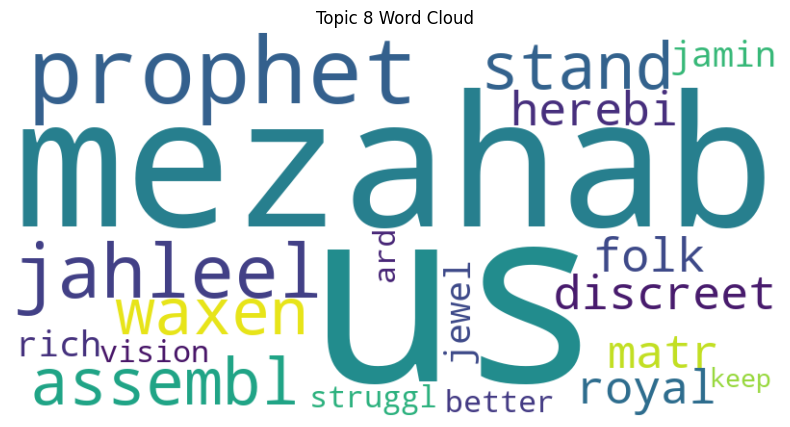

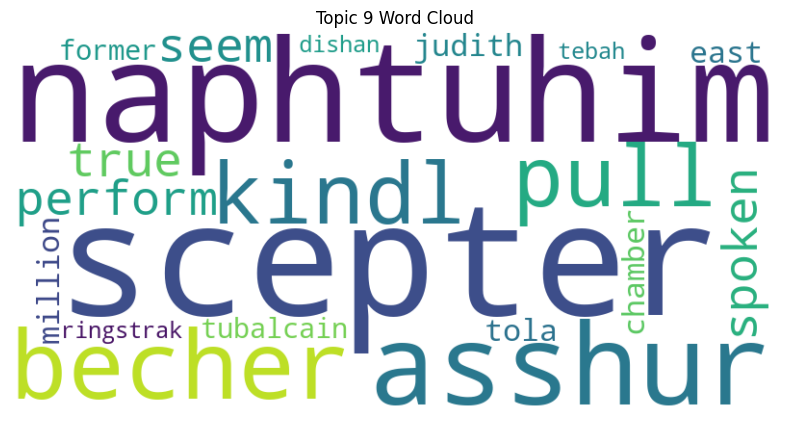

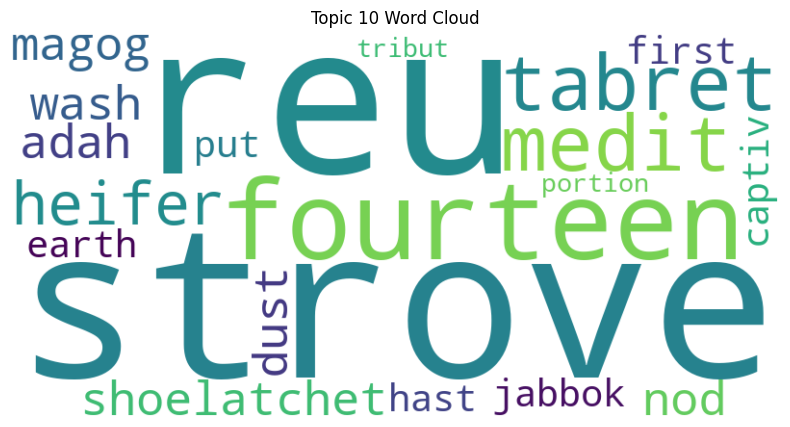

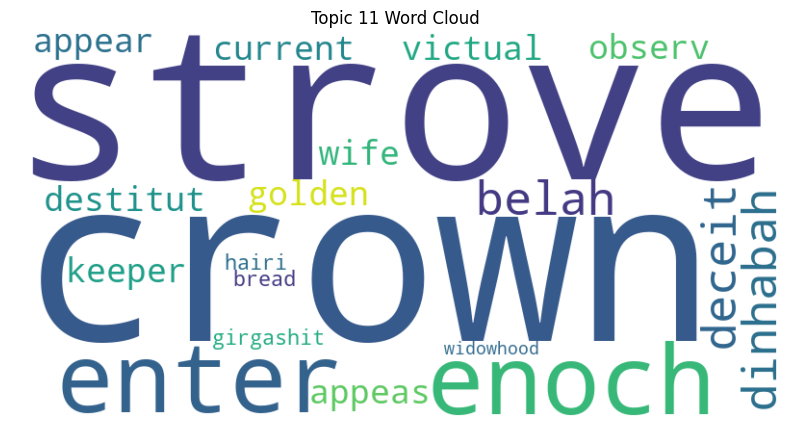

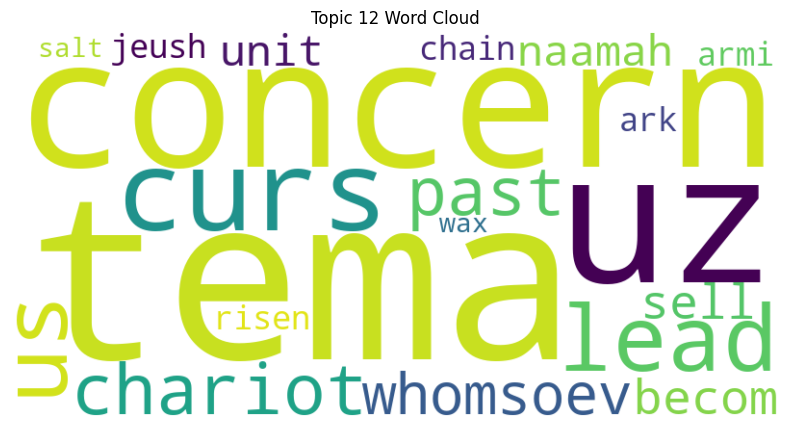

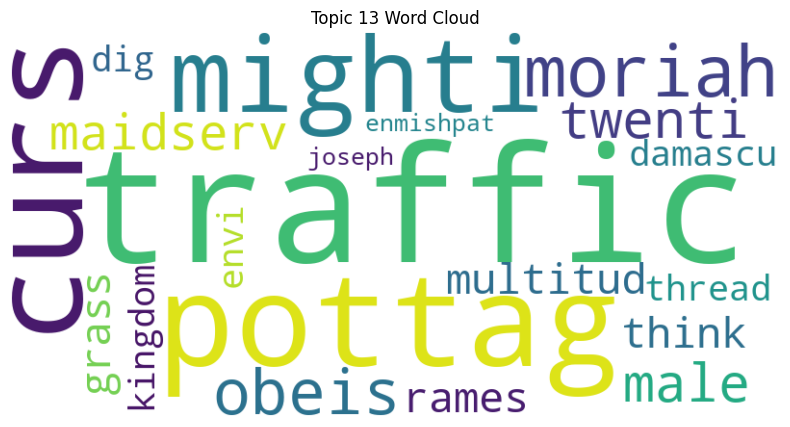

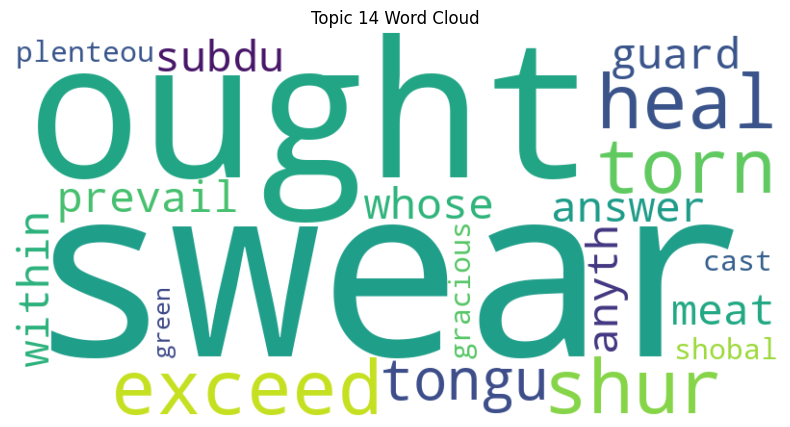

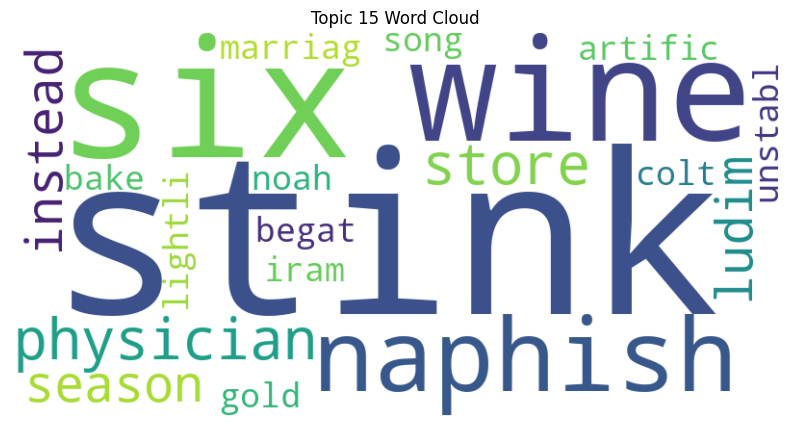

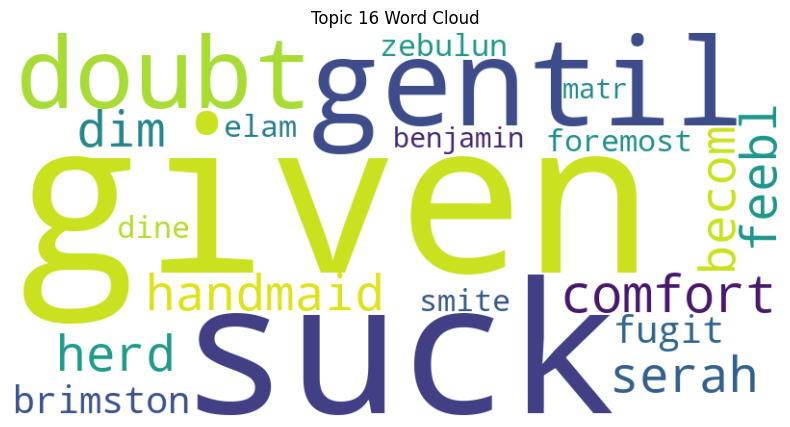

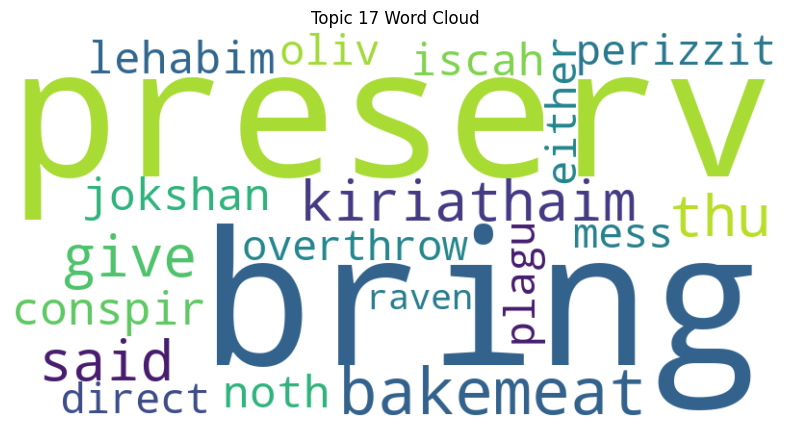

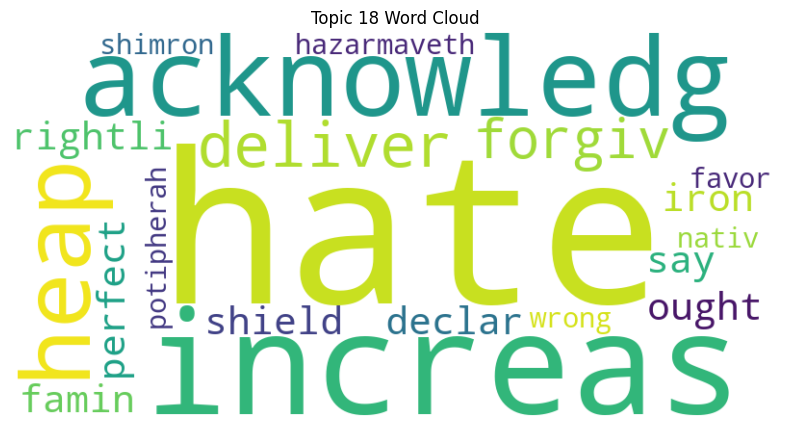

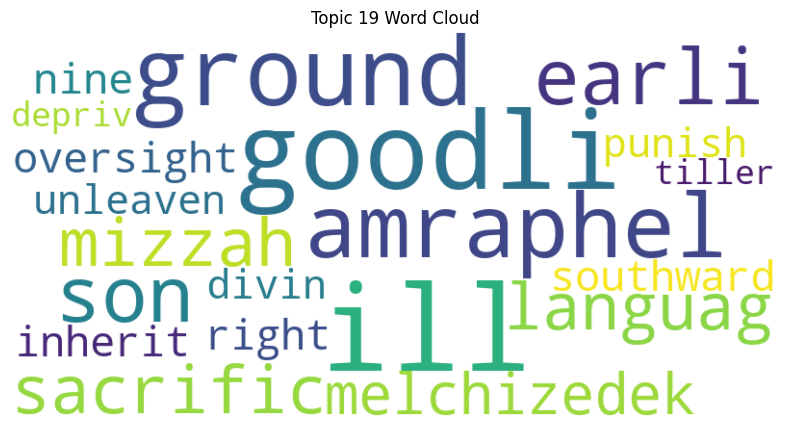

IndexError: index 90 is out of bounds for axis 0 with size 20

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Function to create word clouds for each topic
def create_wordclouds(hdp_model):
    topics = hdp_model.show_topics()
    for topic_id, topic in topics:
        word_freq = {word: float(freq) for freq, word in [pair.split('*') for pair in topic.split(' + ')]}
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id} Word Cloud')
        plt.axis('off')
        plt.show()

# Function to plot topic distribution across documents
def plot_topic_distribution(hdp_model, corpus):
    topic_dist = hdp_model[corpus]
    topics = [dict(topic) for topic in topic_dist]
    topic_matrix = np.zeros((len(corpus), len(hdp_model.show_topics())))

    for doc_id, doc_topics in enumerate(topics):
        for topic_id, topic_prob in doc_topics.items():
            topic_matrix[doc_id][topic_id] = topic_prob

    plt.figure(figsize=(12, 6))
    plt.imshow(topic_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='Probability')
    plt.title('Topic Distribution across Documents')
    plt.xlabel('Topic')
    plt.ylabel('Document')
    plt.show()

# Assuming `hdp_model` and `corpus` are already defined

# Visualize word clouds for each topic
create_wordclouds(hdp_model)

# Visualize topic distribution across documents
plot_topic_distribution(hdp_model, corpus)


In [26]:
from gensim import corpora, models

# Create a list of tokenized documents
documents = [[word for word in word_counts.keys()] for word_counts in dtm.values()]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(documents)

# Create a bag-of-words representation of the corpus
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Apply LSA
num_topics = 5
lsa_model = models.LsiModel(corpus, num_topics=num_topics, id2word=dictionary)

# Print the topics
print("Top words for each topic:")
for topic_idx, topic in lsa_model.print_topics(num_words=10):
    print(f"Topic {topic_idx}: {topic}")


Top words for each topic:
Topic 0: 0.572*"said" + 0.241*"son" + 0.234*"shall" + 0.232*"god" + 0.206*"lord" + 0.190*"father" + 0.159*"brother" + 0.155*"jacob" + 0.150*"came" + 0.138*"land"
Topic 1: 0.595*"son" + -0.419*"said" + 0.208*"daughter" + 0.205*"year" + 0.195*"jacob" + 0.182*"came" + -0.166*"lord" + 0.147*"hundr" + -0.141*"shall" + 0.127*"begat"
Topic 2: -0.347*"son" + 0.336*"came" + 0.311*"land" + -0.276*"said" + 0.257*"joseph" + 0.234*"brother" + 0.222*"father" + -0.220*"god" + 0.193*"pass" + 0.181*"egypt"
Topic 3: -0.472*"shall" + 0.412*"said" + -0.295*"god" + -0.262*"earth" + 0.218*"jacob" + -0.196*"everi" + -0.181*"year" + -0.164*"live" + -0.150*"day" + -0.148*"lord"
Topic 4: -0.450*"shall" + 0.444*"god" + 0.363*"came" + 0.198*"pass" + -0.184*"year" + 0.149*"lord" + -0.142*"son" + 0.140*"abraham" + -0.136*"said" + 0.130*"earth"


In [29]:

# Preprocess the text
preprocessed_text = preprocess_text(eng_genesis_text)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_text)

# Apply SVD to the TF-IDF matrix
n_components = 10 # Number of topics
lsa_model = TruncatedSVD(n_components=n_components, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(X)

# Print the top words for each topic and calculate coherence
terms = vectorizer.get_feature_names_out()
for i, topic in enumerate(lsa_model.components_):
    top_terms_idx = topic.argsort()[:-11:-1]
    top_terms = [terms[idx] for idx in top_terms_idx]
    print(f"Topic {i}: {' | '.join(top_terms)}")


Topic 0: said | daughter | name | hand | us | hous | come | earth | everi | esau
Topic 1: shall | behold | daughter | earth | name | brother | go | esau | one | servant
Topic 2: son | wife | isaac | call | everi | daughter | pass | abraham | earth | let
Topic 3: god | man | behold | daughter | wife | brother | hous | lord | took | call
Topic 4: lord | father | hand | wife | came | joseph | everi | isaac | pharaoh | went
Topic 5: father | behold | say | brother | daughter | abraham | earth | took | us | name
Topic 6: land | behold | abraham | brother | man | wife | also | let | name | jacob
Topic 7: jacob | came | brother | behold | hand | say | us | egypt | day | took
Topic 8: came | brother | man | behold | go | pass | abraham | daughter | year | bless
Topic 9: brother | joseph | hand | name | pharaoh | went | day | also | wife | year


In [30]:
import math
from collections import Counter
# Compute coherence score
def compute_coherence_score_lsa(terms, text):
    di = {}
    for term in terms:
        if term in text:
            if term in di:
                di[term] += text.count(term)  # Increment the count of the term by its frequency in the text
            else:
                di[term] = text.count(term)  # Initialize the count of the term with its frequency in the text
    print(di)
    dij = {(terms[i],terms[i+1]):0 for i in range(len(terms)-1)}
    for val, count in dij.items():
        f, s = val
        for i in range(len(text)-1):
            if(text[i] == f and text[i+1] == s):
                dij[val] += 1
    print(dij)
    coherence = 0
    for val, count in dij.items():
        f, s = val
        coherence += ((dij[val] + 1) / di[f]) 

    return coherence

def compute_coherence_score_uci(terms, text):
    di = Counter(text)
    dij = {(terms[i], terms[j]): 0 for i in range(len(terms)) for j in range(i + 1, len(terms))}
    for val, count in dij.items():
        f, s = val
        for i in range(len(text) - 1):
            if text[i] == f and text[i + 1] == s:
                dij[val] += 1

    coherence = 0
    total_pairs = 0
    for val, count in dij.items():
        f, s = val
        pmi = ((dij[val] + 1) * len(text) / (di[f] * di[s]))
        coherence += pmi
        total_pairs += 1

    return coherence / total_pairs

cumulative_coherence = 0
cumulative_uci = 0
for i, topic in enumerate(lsa_model.components_):
    top_terms_idx = topic.argsort()[:-11:-1]
    top_terms = [terms[idx] for idx in top_terms_idx]
    cumulative_coherence += compute_coherence_score_lsa(top_terms, preprocessed_text)
    cumulative_uci += compute_coherence_score_uci(top_terms, preprocessed_text)

print("Coherence Score:", math.log(cumulative_coherence))
print("Coherence Score UCI:", math.log(cumulative_uci))

{'said': 489, 'daughter': 110, 'name': 114, 'hand': 108, 'us': 94, 'hous': 87, 'come': 87, 'earth': 121, 'everi': 91, 'esau': 76}
{('said', 'daughter'): 2, ('daughter', 'name'): 1, ('name', 'hand'): 0, ('hand', 'us'): 0, ('us', 'hous'): 0, ('hous', 'come'): 0, ('come', 'earth'): 1, ('earth', 'everi'): 7, ('everi', 'esau'): 0}
{'shall': 333, 'behold': 118, 'daughter': 110, 'earth': 121, 'name': 114, 'brother': 173, 'go': 86, 'esau': 76, 'one': 78, 'servant': 83}
{('shall', 'behold'): 0, ('behold', 'daughter'): 0, ('daughter', 'earth'): 0, ('earth', 'name'): 0, ('name', 'brother'): 1, ('brother', 'go'): 0, ('go', 'esau'): 0, ('esau', 'one'): 0, ('one', 'servant'): 0}
{'son': 306, 'wife': 104, 'isaac': 80, 'call': 106, 'everi': 91, 'daughter': 110, 'pass': 90, 'abraham': 134, 'earth': 121, 'let': 93}
{('son', 'wife'): 4, ('wife', 'isaac'): 0, ('isaac', 'call'): 1, ('call', 'everi'): 1, ('everi', 'daughter'): 0, ('daughter', 'pass'): 0, ('pass', 'abraham'): 1, ('abraham', 'earth'): 0, ('ea

In [41]:
if response.status_code == 200:
    text = response.text

    # Preprocess the text
    preprocessed_text = preprocess_text(text)

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(preprocessed_text)

    # Apply NMF to the TF-IDF matrix
    n_components = 10  # Number of topics
    nmf_model = NMF(n_components=n_components, random_state=42)
    nmf_topic_matrix = nmf_model.fit_transform(X)

    # Get the feature names (tokens)
    feature_names = vectorizer.get_feature_names_out()

    # Print topics, tokens, and corresponding vectors
    print("Topics, tokens, and corresponding vectors:")
    for i, topic_vector in enumerate(nmf_model.components_):
        print(f"Topic {i+1}:")
        for token, weight in zip(feature_names, topic_vector):
            print(f"{token}: {weight}")
        print()

else:
    print("Failed to fetch data from the URL:", response.status_code)


Topics, tokens, and corresponding vectors:
Topic 1:
1001: 1.5341899963992022e-191
1002: 1.5341899963992022e-191
1003: 1.5341899963992022e-191
1004: 1.5341899963992022e-191
1005: 1.5341899963992022e-191
101: 6.063769474816639e-120
1010: 1.6594035809914565e-120
1011: 6.063769474816639e-120
1012: 1.6594035809914565e-120
1013: 4.373671586383436e-121
1014: 4.373671586383436e-121
1015: 1.1077732115540044e-121
1016: 2.689687771410085e-122
1017: 2.689687771410085e-122
1018: 2.689687771410085e-122
1019: 5.781498873781912e-125
102: 6.063769474816639e-120
1020: 1.912165167291528e-126
1021: 3.147609262056477e-127
10210: 1.5341899963992022e-191
10211: 1.5341899963992022e-191
10212: 1.5341899963992022e-191
10213: 1.5341899963992022e-191
10214: 1.5341899963992022e-191
10215: 1.5341899963992022e-191
10216: 1.5341899963992022e-191
10217: 1.5341899963992022e-191
10218: 1.5341899963992022e-191
10219: 1.5341899963992022e-191
1022: 6.795103048053359e-129
10220: 1.5341899963992022e-191
10221: 1.534189996399

In [42]:
    # Print the topics
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic {topic_idx + 1}:")
        top_idx = topic.argsort()[:-11:-1]
        top_terms = [feature_names[i] for i in top_idx]
        print(", ".join(top_terms))

Topic 1:
shall, psalm, come, hous, peopl, came, one, children, chronicl, land
Topic 2:
lord, come, hous, peopl, came, hand, also, land, thing, children
Topic 3:
said, psalm, come, hous, came, peopl, one, hand, also, children
Topic 4:
god, psalm, come, peopl, hous, came, one, hand, children, chronicl
Topic 5:
king, psalm, come, one, hous, peopl, came, hand, also, children
Topic 6:
son, psalm, come, one, hand, peopl, came, land, also, go
Topic 7:
man, hous, peopl, came, one, also, thing, men, genesi, jeremiah
Topic 8:
day, psalm, come, hand, chronicl, number, genesi, made, offer, isaiah
Topic 9:
say, hous, came, hand, chronicl, thing, go, genesi, father, us
Topic 10:
israel, psalm, come, one, hand, also, thing, men, land, samuel
